## Develop Sentence Segmentor for Siam Zone Lyrics

In [1]:
#adapted from @bact at https://colab.research.google.com/drive/1hdtmwTXHLrqNmDhDqHnTQGpDVy1aJc4t
import pandas as pd
import numpy as np
import re
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import pycrfsuite
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from pythainlp.tokenize import word_tokenize, syllable_tokenize
from pythainlp.tag import pos_tag
token_func = word_tokenize #syllable_tokenize

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 50)

import pythainlp
pythainlp.__version__

'2.2.5'

In [4]:
df = pd.read_pickle('data/siamzone_lyrics_line_tokenized.pickle')
df['line_tokenized'] = df.line_tokenized.map(lambda x: ' |'.join(x.split('|')))
df['line_tokenized'] = df.line_tokenized + ' '
df

,song_title,artist_name,line_tokenized
0,ฉันสวย,001,ก้น ไม่มี ก้น ไม่มี ก้น ไม่มี |ก็ก้นหนูลาป่วย ...
1,นาทีที่เจ็ด (นาทีที่เจ็บ),001,กี่พันวันที่ดีครั้งนั้น ถูกทำลายลงหมดไม่เหลือ ...
2,ยอมตั้งแต่หน้าประตู,001,หมื่นเหตุผลที่ทิ้งฉันไป กี่พันคำที่เธอคร่ำครวญ...
3,ไม่ไว้ใจ,1011,บอกเขาว่ายินดี ได้เจอกันสักที ฟังเรื่องเขามามา...
4,เวลาที่หายไป,1011,เช้าทีไรอยากหลับตาไม่ต้องการตื่นขึ้นมา |เจอใคร...
...,...,...,...
18147,เอาเป็นว่าฉันรักใครไม่เป็น,จิ๊กซอว์ สตอรี่ Jigsaw Story,เอาเป็นว่าฉันรักๆ ใครไม่เป็น |เป็นอยู่แบบนี้ฉั...
18148,น้อนคาบไป (นกสีน้ำตาล),พอส Pause,ตอนที่ฉันบอกรักเธอ |มีนกบินมาตัวหนึ่ง เธอเลยไม...
18149,อีหล่า (Ost. อีหล่าเอ๋ย),ตูมตาม ยุทธนา เปื้องกลาง,ลาลันลาอีหล่า ลาลันลาอีหล่า |ลาลันลาอีหล่า ลัน...
18150,กลิ่นลาบที่สีลม,รวมศิลปิน,ผู้เฒ่าเพิ่นว่า หม่องใด๋ ที่ใด๋ มีกลิ่นลาบงัว ...


## Splits

In [5]:
# Split train and test set at 80/20 proportion
train_lines, test_lines, _, _ = train_test_split(df.line_tokenized, 
                                                    df.song_title, 
                                                    test_size=0.2, 
                                                    random_state=1412)
train_lines = [i for i in train_lines]
test_lines = [i for i in test_lines]

## Word-Label Tuples

In [8]:
def generate_tuples(all_sentences):
    all_tuples = []
    for i in tqdm(range(len(all_sentences))):
        tuples = []
        for s in all_sentences[i].split('|'):
            s_lst = word_tokenize(s)
            for j in range(len(s_lst)):
                lab = 'E' if j==len(s_lst)-1 else 'I'
                tuples.append((s_lst[j],lab))
        all_tuples.append(tuples)
    return all_tuples

train_tuples = generate_tuples(train_lines)
test_tuples = generate_tuples(test_lines)

In [9]:
len(train_tuples), len(test_tuples)

(14521, 3631)

In [10]:
train_tuples[0][:10]

[('ทำไม', 'I'),
 ('ไม่', 'I'),
 ('พูด', 'I'),
 ('ดี', 'I'),
 ('ๆ', 'I'),
 (' ', 'I'),
 ('ทำไม', 'I'),
 ('ต้อง', 'I'),
 ('แกล้ง', 'I'),
 ('เธอ', 'I')]

## Explore Features

We'll use only train set for feature engineering to avoid leakage.

### Starters and Enders

In [11]:
%%time
def generate_tuple_df(all_tuples):
    tuple_dfs = [pd.DataFrame(i) for i in all_tuples]
    tuple_df = pd.concat(tuple_dfs).reset_index(drop=True)
    tuple_df.columns = ['word','label']
    tuple_df['next_lab'] = tuple_df.label.shift(-1)
    tuple_df['previous_lab'] = tuple_df.label.shift(1)
    return tuple_df

train_tuple_df = generate_tuple_df(train_tuples)
test_tuple_df = generate_tuple_df(test_tuples)

CPU times: user 10.8 s, sys: 399 ms, total: 11.2 s
Wall time: 11.4 s


In [12]:
top_starters = train_tuple_df[train_tuple_df.previous_lab=='E'].word.value_counts()
top_enders = train_tuple_df[train_tuple_df.next_lab=='E'].word.value_counts()
len(top_starters),len(top_enders)

(10707, 16064)

<AxesSubplot:>

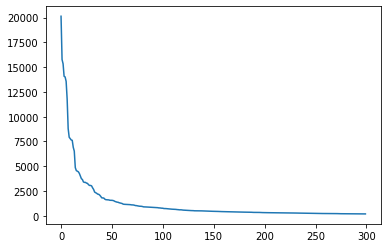

In [13]:
top_starters.reset_index().word.head(300).plot()

In [14]:
top_starters[:50]

ไม่        20136
เธอ        15765
ฉัน        15337
ก็         14074
แต่        14010
จะ         13562
อยาก       11776
ให้         8791
แค่         7925
ถ้า         7788
ที่         7648
และ         7613
มัน         6905
อย่า        6527
เพราะ       4863
รัก         4559
ว่า         4496
คน          4436
เมื่อ       4268
มี          3996
อยู่        3740
ได้         3656
ขอ          3412
เป็น        3370
ใน          3368
หาก         3296
ต้อง        3266
บอก         3136
แล้ว        3060
ยัง         3060
แม้         3017
I           2819
รู้         2654
ใจ          2391
ไม่ต้อง     2329
เรา         2266
ถึง         2184
มา          2163
เหมือน      2080
ยิ่ง        1954
ใคร         1810
คง          1795
บ่          1786
อ้าย        1677
สิ่ง        1624
จาก         1618
เจ็บ        1609
ช่วย        1597
หรือ        1563
กับ         1562
Name: word, dtype: int64

<AxesSubplot:>

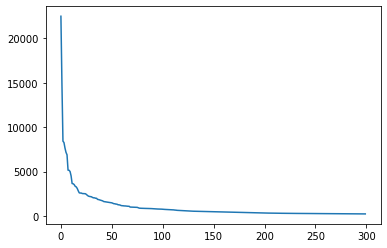

In [15]:
top_enders.reset_index().word.head(300).plot()

In [22]:
top_enders.reset_index()['index'].tolist()

['เธอ',
 'ไป',
 'กัน',
 'ไหม',
 'ฉัน',
 'หัวใจ',
 'ใคร',
 'ไหน',
 'ใจ',
 'เลย',
 'มา',
 'ดี',
 'เข้าใจ',
 'ได้',
 'ๆ',
 'อะไร',
 'นี้',
 'เท่าไร',
 'อยู่',
 'เจอ',
 'ไว้',
 'รัก',
 'แล้ว',
 'รู้',
 'เรา',
 'นั้น',
 'ไกล',
 'เขา',
 'เสียใจ',
 'มี',
 'ไหว',
 'พอ',
 'หรือเปล่า',
 'สักที',
 'ใหม่',
 'ยังไง',
 'คน',
 'ใช่ไหม',
 'ตาย',
 'เท่านั้น',
 'อย่างนี้',
 'นะ',
 'ที',
 'อย่างไร',
 'มากมาย',
 'เก่า',
 'น้ำตา',
 'นาน',
 'ทุกวัน',
 'คนเดียว',
 'เสมอ',
 'ตรงนี้',
 'ทุกอย่าง',
 'ฝัน',
 '...',
 'เอาไว้',
 'เอง',
 'กลับมา',
 'เหมือนเดิม',
 'ทำไม',
 'มัน',
 'ต่อไป',
 'ด้วยกัน',
 'ต้องการ',
 'เหลือเกิน',
 'ก่อน',
 'ไง',
 'you',
 'อย่างนั้น',
 'ตลอดไป',
 'เปลี่ยนไป',
 'จากไป',
 'ทุกที',
 'วันนี้',
 'สนใจ',
 'มีความหมาย',
 'ฟัง',
 'แบบนี้',
 'เหงา',
 'รอ',
 'บ่',
 'ว่า',
 'เข้ามา',
 'วัน',
 'หวั่นไหว',
 'เดิม',
 'คนดี',
 'ข้างใน',
 'ลืม',
 'บอก',
 'อีกครั้ง',
 'จริง',
 'หน่อย',
 'อ้าย',
 'เท่าไหร่',
 'ความรัก',
 'ทำ',
 'me',
 'สักครั้ง',
 '.',
 'กาย',
 'เกินไป',
 'จริงๆ',
 'เรื่อยไป',
 'สำคัญ',


In [19]:
enders

เธอ          22474
ไป           14860
กัน           8426
ไหม           8272
ฉัน           7649
หัวใจ         7168
ใคร           6893
ไหน           5167
ใจ            5157
เลย           5010
มา            4521
ดี            3665
เข้าใจ        3637
ได้           3548
ๆ             3357
อะไร          3288
นี้           3119
เท่าไร        2849
อยู่          2617
เจอ           2595
ไว้           2594
รัก           2541
แล้ว          2537
รู้           2529
เรา           2518
นั้น          2440
ไกล           2333
เขา           2249
เสียใจ        2215
มี            2198
ไหว           2174
พอ            2100
หรือเปล่า     2058
สักที         2056
ใหม่          2010
ยังไง         2006
คน            1882
ใช่ไหม        1861
ตาย           1822
เท่านั้น      1789
อย่างนี้      1744
นะ            1715
ที            1640
อย่างไร       1620
มากมาย        1596
เก่า          1592
น้ำตา         1558
นาน           1543
ทุกวัน        1531
คนเดียว       1511
Name: word, dtype: int64

## Feature Extraction

In [59]:
enders = top_enders[:50]
starters = top_starters[:50]

def extract_features(doc, window=3, max_n_gram=3):
#     #paddings for POS
#     doc_pos = ['xxpad' for i in range(window)] + \
#         [p for (w,p) in pos_tag(doc,engine='perceptorn', corpus='orchid')] + ['xxpad' for i in range(window)]
    
    #padding for words
    doc = ['xxpad' for i in range(window)] + doc + ['xxpad' for i in range(window)]
    
    doc_ender = []
    doc_starter = []
    #add enders
    for i in range(len(doc)):
        if doc[i] in enders:
            doc_ender.append('ender')
        else:
            doc_ender.append('normal')
    #add starters
    for i in range(len(doc)):
        if doc[i] in starters:
            doc_starter.append('starter')
        else:
            doc_starter.append('normal')
            
    doc_features = []
    #for each word
    for i in range(window, len(doc)-window):
        #bias term
        word_features = ['bias'] 
        
        #ngram features
        for n_gram in range(1, min(max_n_gram+1,2+window*2)):
            for j in range(i-window,i+window+2-n_gram):
                feature_position = f'{n_gram}_{j-i}_{j-i+n_gram}'
                
                #word
                word_ = f'{"|".join(doc[j:(j+n_gram)])}'
                word_features += [f'word_{feature_position}={word_}']
                
#                #pos
#                 pos_ =f'{"|".join(doc_pos[j:(j+n_gram)])}'
#                 word_features += [f'pos_{feature_position}={pos_}']
    
                #enders
                ender_ =  f'{"|".join(doc_ender[j:(j+n_gram)])}'
                word_features += [f'ender_{feature_position}={ender_}']
                
                #starters
                starter_ =  f'{"|".join(doc_starter[j:(j+n_gram)])}'
                word_features += [f'starter_{feature_position}={starter_}']
        
        #number of tokens to the left and right
        nb_left = 0
        for l in range(i)[::-1]:
            if doc[l]=='<space>': break
            if True: nb_left+=1.0
        nb_right = 0
        for r in range(i+1,len(doc)):
            if doc[r]=='<space>': break
            if True: nb_right+=1.0
        word_features += [f'nb_left={nb_left}',f'nb_right={nb_right}']
        
        #append to feature per word
        doc_features.append(word_features)
    return doc_features

In [60]:
%%time
def generate_xy(all_tuples):
    #target
    y = [[l for (w,l) in t] for t in all_tuples]
    #features
    x_pre = [[w for (w,l) in t] for t in all_tuples]
    x = [extract_features(x_, window=3, max_n_gram = 3) for x_ in tqdm(x_pre)]
    return x, y

x_train, y_train = generate_xy(train_tuples[:100])
x_test, y_test = generate_xy(test_tuples[:100])


CPU times: user 5.8 s, sys: 149 ms, total: 5.95 s
Wall time: 5.97 s


In [63]:
len(x_train),len(y_train),len(x_test),len(y_test)

(100, 100, 100, 100)

In [82]:
test_tuples[0]
words  = [tup[0] for li in test_tuples[:100] for tup in li]
baselines = [labels['E'] if word==' ' else labels['I'] for word in words]
baselines[:10]

[1, 1, 1, 1, 0, 1, 1, 1, 1, 1]

In [19]:
%%time
# Train model
trainer = pycrfsuite.Trainer(verbose=True)

for xseq, yseq in tqdm(zip(x_train, y_train)):
    trainer.append(xseq, yseq)

trainer.set_params({
    'c1': 1.0,
    'c2': 0.0,
    'max_iterations': 500,
    'feature.possible_transitions': True,
    'feature.minfreq': 2.0
})

trainer.train('models/song-crf.model')


Feature generation
type: CRF1d
feature.minfreq: 2.000000
feature.possible_states: 0
feature.possible_transitions: 1
0....1....2....3....4....5....6....7....8....9....10
Number of features: 80508
Seconds required: 1.025

L-BFGS optimization
c1: 1.000000
c2: 0.000000
num_memories: 6
max_iterations: 500
epsilon: 0.000010
stop: 10
delta: 0.000010
linesearch: MoreThuente
linesearch.max_iterations: 20

***** Iteration #1 *****
Loss: 19989.506772
Feature norm: 1.000000
Error norm: 21586.945686
Active features: 50842
Line search trials: 1
Line search step: 0.000013
Seconds required for this iteration: 0.096

***** Iteration #2 *****
Loss: 15606.909450
Feature norm: 0.812139
Error norm: 20306.436198
Active features: 34825
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.051

***** Iteration #3 *****
Loss: 12174.663841
Feature norm: 0.518861
Error norm: 38643.407521
Active features: 16597
Line search trials: 3
Line search step: 0.250000
Seconds required fo

***** Iteration #39 *****
Loss: 3065.990396
Feature norm: 12.058127
Error norm: 1395.609115
Active features: 13427
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.046

***** Iteration #40 *****
Loss: 3029.173045
Feature norm: 12.612559
Error norm: 836.098396
Active features: 13335
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.048

***** Iteration #41 *****
Loss: 3009.342678
Feature norm: 13.321355
Error norm: 1095.041092
Active features: 13277
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.045

***** Iteration #42 *****
Loss: 2981.706491
Feature norm: 13.865808
Error norm: 714.621224
Active features: 13212
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.047

***** Iteration #43 *****
Loss: 2964.927138
Feature norm: 14.540547
Error norm: 873.825805
Active features: 13080
Line search trials: 1
Line search step: 1.000000
Seconds

***** Iteration #82 *****
Loss: 2694.998095
Feature norm: 24.612174
Error norm: 60.076934
Active features: 4757
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.042

***** Iteration #83 *****
Loss: 2694.448062
Feature norm: 24.676253
Error norm: 30.353550
Active features: 4701
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.047

***** Iteration #84 *****
Loss: 2693.959838
Feature norm: 24.711835
Error norm: 76.607272
Active features: 4664
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.044

***** Iteration #85 *****
Loss: 2693.510035
Feature norm: 24.783132
Error norm: 53.280741
Active features: 4637
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.045

***** Iteration #86 *****
Loss: 2693.182656
Feature norm: 24.813468
Error norm: 45.617955
Active features: 4648
Line search trials: 1
Line search step: 1.000000
Seconds required fo

***** Iteration #127 *****
Loss: 2687.896833
Feature norm: 25.406862
Error norm: 72.632692
Active features: 4323
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.038

***** Iteration #128 *****
Loss: 2687.816718
Feature norm: 25.408960
Error norm: 59.217281
Active features: 4321
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.039

***** Iteration #129 *****
Loss: 2687.793044
Feature norm: 25.413768
Error norm: 74.862477
Active features: 4302
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.039

***** Iteration #130 *****
Loss: 2687.714837
Feature norm: 25.415709
Error norm: 60.673354
Active features: 4305
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.035

***** Iteration #131 *****
Loss: 2687.674958
Feature norm: 25.421276
Error norm: 59.887391
Active features: 4312
Line search trials: 1
Line search step: 1.000000
Seconds requir

***** Iteration #169 *****
Loss: 2685.894116
Feature norm: 25.464907
Error norm: 19.351862
Active features: 4277
Line search trials: 2
Line search step: 0.500000
Seconds required for this iteration: 0.090

***** Iteration #170 *****
Loss: 2685.870926
Feature norm: 25.466094
Error norm: 37.173480
Active features: 4275
Line search trials: 2
Line search step: 0.500000
Seconds required for this iteration: 0.088

***** Iteration #171 *****
Loss: 2685.827596
Feature norm: 25.469820
Error norm: 33.734273
Active features: 4272
Line search trials: 2
Line search step: 0.500000
Seconds required for this iteration: 0.089

***** Iteration #172 *****
Loss: 2685.795917
Feature norm: 25.469763
Error norm: 45.804893
Active features: 4274
Line search trials: 2
Line search step: 0.500000
Seconds required for this iteration: 0.088

***** Iteration #173 *****
Loss: 2685.755623
Feature norm: 25.474132
Error norm: 41.641319
Active features: 4270
Line search trials: 2
Line search step: 0.500000
Seconds requir

***** Iteration #211 *****
Loss: 2684.401123
Feature norm: 25.484585
Error norm: 40.914221
Active features: 4214
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.045

***** Iteration #212 *****
Loss: 2684.363491
Feature norm: 25.486876
Error norm: 41.006385
Active features: 4212
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.051

***** Iteration #213 *****
Loss: 2684.342720
Feature norm: 25.488485
Error norm: 43.836154
Active features: 4210
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.047

***** Iteration #214 *****
Loss: 2684.308013
Feature norm: 25.488772
Error norm: 37.696352
Active features: 4210
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.049

***** Iteration #215 *****
Loss: 2684.287254
Feature norm: 25.489748
Error norm: 43.077986
Active features: 4208
Line search trials: 1
Line search step: 1.000000
Seconds requir

***** Iteration #252 *****
Loss: 2683.462084
Feature norm: 25.493711
Error norm: 31.837895
Active features: 4189
Line search trials: 2
Line search step: 0.500000
Seconds required for this iteration: 0.072

***** Iteration #253 *****
Loss: 2683.450417
Feature norm: 25.494593
Error norm: 55.038997
Active features: 4185
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.037

***** Iteration #254 *****
Loss: 2683.409810
Feature norm: 25.493180
Error norm: 39.299742
Active features: 4175
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.036

***** Iteration #255 *****
Loss: 2683.382390
Feature norm: 25.493794
Error norm: 28.409318
Active features: 4179
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.035

***** Iteration #256 *****
Loss: 2683.368136
Feature norm: 25.492975
Error norm: 27.864017
Active features: 4176
Line search trials: 1
Line search step: 1.000000
Seconds requir

***** Iteration #292 *****
Loss: 2682.607271
Feature norm: 25.506278
Error norm: 34.412301
Active features: 4150
Line search trials: 2
Line search step: 0.500000
Seconds required for this iteration: 0.073

***** Iteration #293 *****
Loss: 2682.582273
Feature norm: 25.506972
Error norm: 25.526030
Active features: 4150
Line search trials: 2
Line search step: 0.500000
Seconds required for this iteration: 0.083

***** Iteration #294 *****
Loss: 2682.563847
Feature norm: 25.506658
Error norm: 35.240371
Active features: 4150
Line search trials: 2
Line search step: 0.500000
Seconds required for this iteration: 0.086

***** Iteration #295 *****
Loss: 2682.538121
Feature norm: 25.507153
Error norm: 27.670539
Active features: 4148
Line search trials: 2
Line search step: 0.500000
Seconds required for this iteration: 0.095

***** Iteration #296 *****
Loss: 2682.523024
Feature norm: 25.506919
Error norm: 39.644160
Active features: 4146
Line search trials: 2
Line search step: 0.500000
Seconds requir

***** Iteration #338 *****
Loss: 2681.831922
Feature norm: 25.539418
Error norm: 28.414716
Active features: 4132
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.036

***** Iteration #339 *****
Loss: 2681.828272
Feature norm: 25.541899
Error norm: 35.547668
Active features: 4134
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.037

***** Iteration #340 *****
Loss: 2681.807255
Feature norm: 25.541845
Error norm: 23.370534
Active features: 4132
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.039

***** Iteration #341 *****
Loss: 2681.802927
Feature norm: 25.544298
Error norm: 30.512916
Active features: 4136
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.038

***** Iteration #342 *****
Loss: 2681.789275
Feature norm: 25.544632
Error norm: 25.313478
Active features: 4126
Line search trials: 1
Line search step: 1.000000
Seconds requir

***** Iteration #380 *****
Loss: 2681.431402
Feature norm: 25.570984
Error norm: 19.301417
Active features: 4136
Line search trials: 2
Line search step: 0.500000
Seconds required for this iteration: 0.088

***** Iteration #381 *****
Loss: 2681.419235
Feature norm: 25.572081
Error norm: 15.279857
Active features: 4136
Line search trials: 2
Line search step: 0.500000
Seconds required for this iteration: 0.087

***** Iteration #382 *****
Loss: 2681.414168
Feature norm: 25.573052
Error norm: 27.017116
Active features: 4136
Line search trials: 2
Line search step: 0.500000
Seconds required for this iteration: 0.075

***** Iteration #383 *****
Loss: 2681.401011
Feature norm: 25.573551
Error norm: 20.639360
Active features: 4131
Line search trials: 2
Line search step: 0.500000
Seconds required for this iteration: 0.068

***** Iteration #384 *****
Loss: 2681.393008
Feature norm: 25.573885
Error norm: 24.981279
Active features: 4136
Line search trials: 2
Line search step: 0.500000
Seconds requir

***** Iteration #427 *****
Loss: 2680.968786
Feature norm: 25.576840
Error norm: 19.991185
Active features: 4112
Line search trials: 2
Line search step: 0.500000
Seconds required for this iteration: 0.070

***** Iteration #428 *****
Loss: 2680.961928
Feature norm: 25.576027
Error norm: 21.156931
Active features: 4112
Line search trials: 2
Line search step: 0.500000
Seconds required for this iteration: 0.066

***** Iteration #429 *****
Loss: 2680.951732
Feature norm: 25.576292
Error norm: 17.999080
Active features: 4110
Line search trials: 2
Line search step: 0.500000
Seconds required for this iteration: 0.067

***** Iteration #430 *****
Loss: 2680.946199
Feature norm: 25.575522
Error norm: 21.317315
Active features: 4110
Line search trials: 2
Line search step: 0.500000
Seconds required for this iteration: 0.068

***** Iteration #431 *****
Loss: 2680.935381
Feature norm: 25.575651
Error norm: 16.625634
Active features: 4110
Line search trials: 2
Line search step: 0.500000
Seconds requir

***** Iteration #467 *****
Loss: 2680.675691
Feature norm: 25.574150
Error norm: 24.795379
Active features: 4089
Line search trials: 2
Line search step: 0.500000
Seconds required for this iteration: 0.067

***** Iteration #468 *****
Loss: 2680.663439
Feature norm: 25.573915
Error norm: 16.089304
Active features: 4089
Line search trials: 2
Line search step: 0.500000
Seconds required for this iteration: 0.074

***** Iteration #469 *****
Loss: 2680.658032
Feature norm: 25.573856
Error norm: 23.593457
Active features: 4089
Line search trials: 2
Line search step: 0.500000
Seconds required for this iteration: 0.069

***** Iteration #470 *****
Loss: 2680.646917
Feature norm: 25.573722
Error norm: 15.617428
Active features: 4089
Line search trials: 2
Line search step: 0.500000
Seconds required for this iteration: 0.068

***** Iteration #471 *****
Loss: 2680.643475
Feature norm: 25.573943
Error norm: 25.194982
Active features: 4089
Line search trials: 2
Line search step: 0.500000
Seconds requir

In [22]:
# ***** Iteration #306 *****
# Loss: 361670.891636
# Feature norm: 311.532287
# Error norm: 1102.739051
# Active features: 303617
# Line search trials: 1
# Line search step: 1.000000
# Seconds required for this iteration: 12.143

# L-BFGS terminated with the stopping criteria
# Total seconds required for training: 3904.962

# Storing the model
# Number of active features: 303617 (4597874)
# Number of active attributes: 209524 (8375394)
# Number of active labels: 2 (2)
# Writing labels
# Writing attributes
# Writing feature references for transitions
# Writing feature references for attributes
# Seconds required: 7.830

In [20]:
# Predict (using test set)
tagger = pycrfsuite.Tagger()
tagger.open('models/song-crf.model')
y_pred = []
for xseq in tqdm(x_test, total=len(x_test)): y_pred.append(tagger.tag(xseq))

In [83]:
# Evaluate at word-level
labels = {'E': 0, "I": 1} # classification_report() needs values in 0s and 1s
predictions = np.array([labels[tag] for row in y_pred for tag in row])
truths = np.array([labels[tag] for row in y_test for tag in row])

print(classification_report(
    truths, baselines,
    target_names=["E", "I"]))

              precision    recall  f1-score   support

           E       0.55      1.00      0.71      3553
           I       1.00      0.90      0.95     30693

    accuracy                           0.91     34246
   macro avg       0.77      0.95      0.83     34246
weighted avg       0.95      0.91      0.92     34246



In [ ]:
np.array([labels[tag] for row in y_test for tag in row])

In [78]:
len(baselines)

1212594

In [81]:
truths[1]

1